# Mountain Car Learning Problem

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gym
from gym import wrappers
import time
from datetime import datetime
import random
from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
sns.set()

## Part 2

### Approach 1

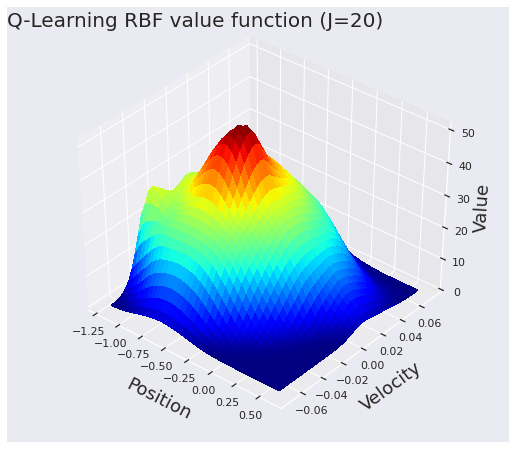

In [146]:
# Some initializations
env_name = "MountainCar-v0"
env = gym.make(env_name)
n_states = 40
episodes = 10 #9000
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
J = 20
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high
xx, yy = np.meshgrid(np.linspace(low[0], high[0], J),
                     np.linspace(low[1], high[1], J))
radials = np.append(xx.reshape(xx.shape + (1,)), yy.reshape(yy.shape + (1,)), axis=2)
radials = radials.reshape((radials.size // 2, 2))
weights = np.random.random((len(actions), J** 2)) * 0.01
sigma_inv = 1 / (high  - low) * J

def basis_function(state):
    r = sigma_inv * (radials - state)
    return np.exp(-0.5 * np.sum(r * r, axis=1))

cum_rewards, step_count3 = [], []
for episode in range(episodes):
    state = env.reset()
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    total_reward, steps = 0, 0
    while True:
        if np.random.uniform(low=0, high=1) < epsilon:
            action = np.random.choice(env.action_space.n)
        else:
            q = [np.dot(basis_function(state), weights[act]) for act in actions]
            action = np.argmax(q)
        obs, reward, terminate, _ = env.step(action)
        basis = basis_function(state)
        pi_v = reward + gamma * max([np.dot(basis_function(obs), weights[a]) for a in actions])
        gradient = np.dot(basis, (pi_v - np.dot(basis, weights[action])))
        weights[action] += alpha * gradient
        total_reward += reward
        steps += 1
        state = obs
        if terminate:
            step_count3.append(steps)
            cum_rewards.append(total_reward)
            break

n_states =40
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], n_states)
ys = np.linspace(low[1], high[1], n_states)
X, Y = np.meshgrid(xs, ys)
states = np.append(X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,)), axis=2)
states = states.reshape((states.shape[0]*states.shape[1], 2,))
q = np.array(list(map(lambda x: max([np.dot(basis_function(x), weights[a]) for a in actions]), states)))
Z = -q.reshape(X.shape)
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf_orig.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

### Approach 2

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


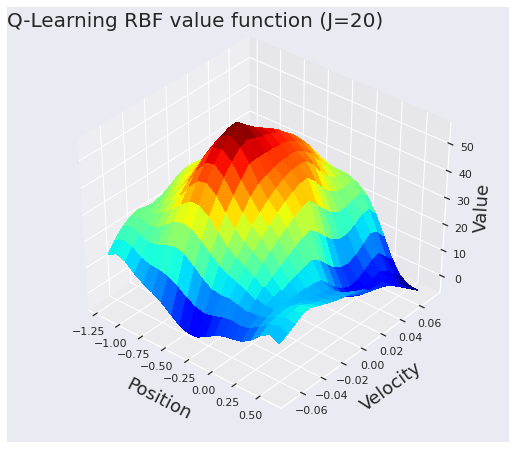

In [134]:
env = gym.make('MountainCar-v0')
episodes = 10
J = 20
gamma = 0.99
epsilon = 0.05
initial_lr = 1.0
min_lr = 0.005
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
rbf_space = [
        ("rbf2", RBFSampler(gamma=2.5, n_components=J)),
        ]
design_matrix = FeatureUnion(rbf_space)
example_features = design_matrix.fit_transform(scaler.transform(observation_examples))
weights = np.random.random((len(actions), J*len(rbf_space))) * 0.01
step_count = []
for episode in range(episodes):
  obs = env.reset()
  steps = 0
  alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
  while True:
    if np.random.uniform(low=0, high=1) < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
      q = [np.dot(X, weights[act]) for act in actions]
      action = np.argmax(q)

    prev_obs = obs
    obs, reward, terminate,_ = env.step(action)

    # update the model
    X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
    G = reward + gamma*max([np.dot(X, weights[a]) for a in actions])
    X = design_matrix.transform(scaler.transform([prev_obs])).reshape(-1)
    gradient = np.dot(X, (G - np.dot(X, weights[action])))
    weights[action] += alpha * gradient
    steps += 1
    if terminate:
      step_count.append(steps)
      break

print(step_count)
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], J)
ys = np.linspace(low[1], high[1], J)
X, Y = np.meshgrid(xs, ys)
states = np.append(X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,)), axis=2)
states = states.reshape((states.shape[0]*states.shape[1], 2,))
q = np.array(list(map(lambda x: max([np.dot(x, weights[a]) for a in actions]), design_matrix.transform(scaler.transform(states)))))
Z = -q.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J*len(rbf_space)) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

[200, 152, 143, 160, 184, 139, 200, 140, 145, 174]


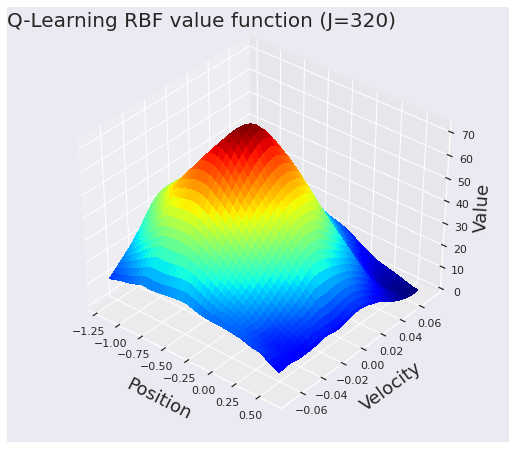

In [144]:
env = gym.make('MountainCar-v0')
episodes = 10
J = 80
gamma = 0.99
epsilon = 0.05
initial_lr = 1.0
min_lr = 0.005
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high
alpha = 0.7

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
rbf_space = [
        ("rbf1", RBFSampler(gamma=5.0, n_components=J)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=J)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=J)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=J))
        ]
design_matrix = FeatureUnion(rbf_space)
example_features = design_matrix.fit_transform(scaler.transform(observation_examples))
weights = np.random.random((len(actions), J*len(rbf_space))) * 0.01
step_count = []
for episode in range(episodes):
  obs = env.reset()
  steps = 0
  while True:
    if np.random.uniform(low=0, high=1) < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
      q = [np.dot(X, weights[act]) for act in actions]
      action = np.argmax(q)

    prev_obs = obs
    obs, reward, terminate,_ = env.step(action)

    # update the model
    X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
    G = reward + gamma*max([np.dot(X, weights[a]) for a in actions])
    X = design_matrix.transform(scaler.transform([prev_obs])).reshape(-1)
    gradient = np.dot(X, (G - np.dot(X, weights[action])))
    weights[action] += alpha * gradient
    steps += 1
    if terminate:
      step_count.append(steps)
      break

print(step_count)
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], J)
ys = np.linspace(low[1], high[1], J)
X, Y = np.meshgrid(xs, ys)
states = np.append(X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,)), axis=2)
states = states.reshape((states.shape[0]*states.shape[1], 2,))
q = np.array(list(map(lambda x: max([np.dot(x, weights[a]) for a in actions]), design_matrix.transform(scaler.transform(states)))))
Z = -q.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J*len(rbf_space)) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf2.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

### Approach 3

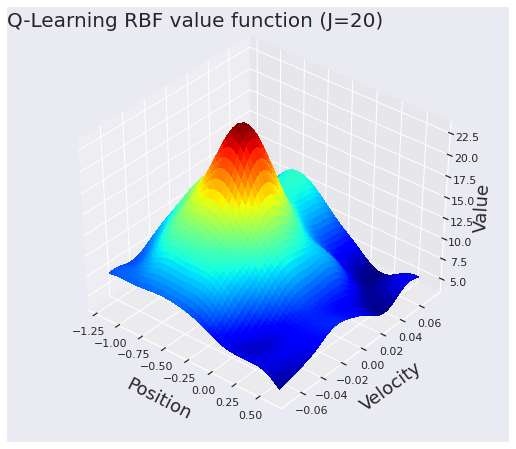

In [143]:
env = gym.make('MountainCar-v0')
episodes = 10
J = 20
gamma = 0.99
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
design_matrix = FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=J)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=J)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=J)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=J))
        ])
example_features = design_matrix.fit_transform(scaler.transform(observation_examples))

models = []
for i in actions:
  model = SGDRegressor(learning_rate='constant')
  model.partial_fit(design_matrix.transform(scaler.transform([env.reset()])), [0])
  models.append(model)

step_count = []
for episode in range(episodes):
  obs = env.reset()
  steps = 0
  epsilon = 0.1*(0.97**episode)
  while True:
    if np.random.uniform(low=0, high=1) < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      X = design_matrix.transform(scaler.transform([obs]))
      result = np.stack([m.predict(X) for m in models]).T
      action = np.argmax(result)

    prev_obs = obs
    obs, reward, terminate,_ = env.step(action)

    # update the model
    X = design_matrix.transform(scaler.transform([obs]))
    next_state = np.stack([m.predict(X) for m in models]).T
    G = reward + gamma*np.max(next_state[0])

    X = design_matrix.transform(scaler.transform([prev_obs]))
    models[action].partial_fit(X, [G])
    steps += 1
    if terminate:
      step_count.append(steps)
      break


fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], J*5)
ys = np.linspace(low[1], high[1], J*5)
X, Y = np.meshgrid(xs, ys)
# both X and Y will be of shape (num_tiles, num_tiles)
Z = np.apply_along_axis(lambda _: -np.max(np.stack([m.predict(design_matrix.transform(scaler.transform([_]))) for m in models]).T), 2, np.dstack([X, Y]))
# Z will also be of shape (num_tiles, num_tiles)
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf_sk.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

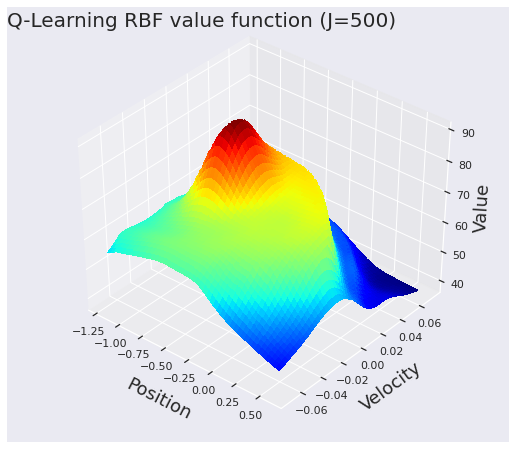

In [136]:
env = gym.make('MountainCar-v0')
episodes = 9000
J = 500
gamma = 0.99
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
design_matrix = FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=J)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=J)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=J)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=J))
        ])
example_features = design_matrix.fit_transform(scaler.transform(observation_examples))

models = []
for i in actions:
  model = SGDRegressor(learning_rate='constant')
  model.partial_fit(design_matrix.transform(scaler.transform([env.reset()])), [0])
  models.append(model)

step_count = []
for episode in range(episodes):
  obs = env.reset()
  steps = 0
  epsilon = 0.1*(0.97**episode)
  while True:
    if np.random.uniform(low=0, high=1) < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      X = design_matrix.transform(scaler.transform([obs]))
      result = np.stack([m.predict(X) for m in models]).T
      action = np.argmax(result)

    prev_obs = obs
    obs, reward, terminate,_ = env.step(action)

    # update the model
    X = design_matrix.transform(scaler.transform([obs]))
    next_state = np.stack([m.predict(X) for m in models]).T
    G = reward + gamma*np.max(next_state[0])

    X = design_matrix.transform(scaler.transform([prev_obs]))
    models[action].partial_fit(X, [G])
    steps += 1
    if terminate:
      step_count.append(steps)
      break


fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], J)
ys = np.linspace(low[1], high[1], J)
X, Y = np.meshgrid(xs, ys)
# both X and Y will be of shape (num_tiles, num_tiles)
Z = np.apply_along_axis(lambda _: -np.max(np.stack([m.predict(design_matrix.transform(scaler.transform([_]))) for m in models]).T), 2, np.dstack([X, Y]))
# Z will also be of shape (num_tiles, num_tiles)
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf_opt.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

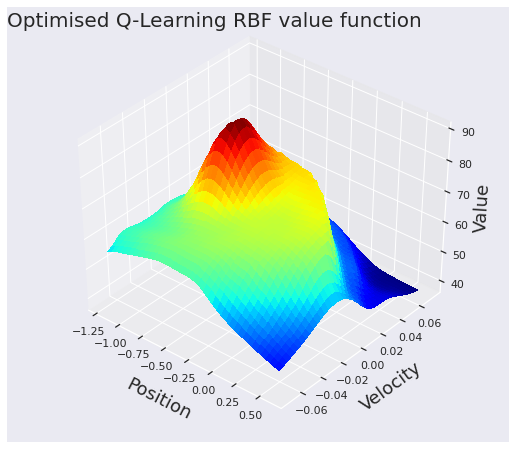

In [138]:
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], 40)
ys = np.linspace(low[1], high[1], 40)
X, Y = np.meshgrid(xs, ys)
# both X and Y will be of shape (num_tiles, num_tiles)
Z = np.apply_along_axis(lambda _: -np.max(np.stack([m.predict(design_matrix.transform(scaler.transform([_]))) for m in models]).T), 2, np.dstack([X, Y]))
# Z will also be of shape (num_tiles, num_tiles)
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Optimised Q-Learning RBF value function', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf_opt.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()